In [1]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [9]:
from torch import bfloat16
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

### overall

- HuggingFace bitsandbytes
- GPTQ: data **compression**, GPU，https://arxiv.org/pdf/2210.17323
    - GPTQ is a **post-training quantization (PTQ)** method for 4-bit quantization that focuses primarily on **GPU** inference and performance.
    - to quantizing the weights of transformer-based models
    - first applies scalar quant to the weights, followed by vector quant to the residuals
    - The idea behind the method is that it will try to **compress all weights to a 4-bit quantization** by minimizing the **mean squared error** to that weight.
        - During inference, it will dynamically dequantize its weights to float16 for improved performance whilst keeping memory low.
- GGUF: ggml, CPU
    - c++, 
    - llama.cpp, https://github.com/ggerganov/llama.cpp
- AWQ：activation aware quantization，https://arxiv.org/abs/2306.00978

## examples

In [14]:
# Latest HF transformers version for Mistral-like models
# !pip install git+https://github.com/huggingface/transformers.git
# !pip install accelerate bitsandbytes xformers

# GPTQ Dependencies
# !pip install optimum
# !pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/
# 我这边走的是源码安装

# GGUF Dependencies
# !pip install 'ctransformers[cuda]'

In [3]:
# Load in your LLM without any compression tricks
model_id = "meta-llama/Meta-Llama-3-8B-Instruct" 
# model_id = "HuggingFaceH4/zephyr-7b-beta"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=bfloat16,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
pipe.model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [8]:
q_proj = pipe.model.model.layers[0].self_attn.q_proj.weight.detach().to(torch.float16).cpu().numpy().flatten()

<Axes: ylabel='Count'>

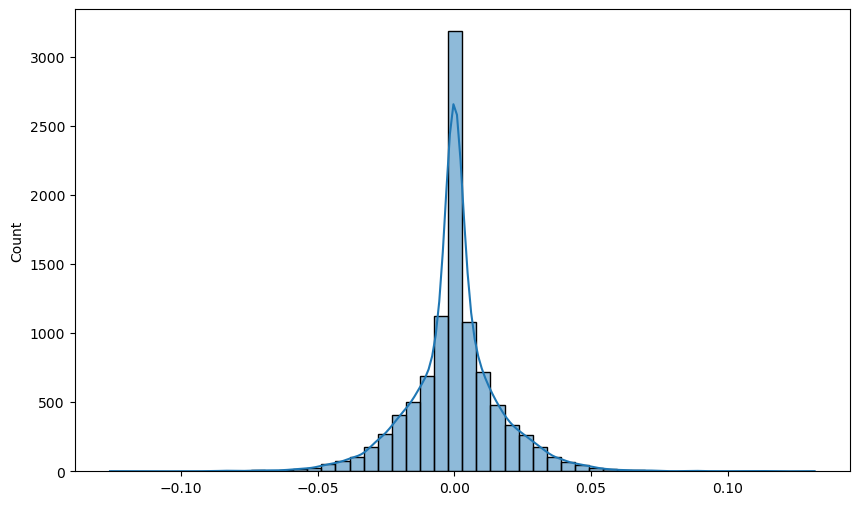

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(q_proj[:10000], bins=50, kde=True)

### chat template

- llama3
    - `<|begin_of_text|>`
    - `<|start_header_id|>system<|end_header_id|>....<|eot_id|>`
    - `<|start_header_id|>user<|end_header_id|>...<|eot_id|>`
    - `<|start_header_id|>assistant<|end_header_id|>...`
- zephyr
    - `<|system|> ... </s>`
    - `<|user|> ... </s>`
    - `<|assistant|> ... </s>`

In [4]:
# See https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot.",
    },
    {
        "role": "user",
        "content": "Tell me a funny joke about Large Language Models."
    },
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [5]:
T = AutoTokenizer.from_pretrained(model_id)
# T

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
# T.encode('<|system|>')

In [40]:
Image(url='https://i.imgur.com/I4bkVwb.png', width=500)

In [41]:
prompt

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nTell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

### generation

In [6]:
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [8]:
(torch.cuda.max_memory_allocated(device='cuda:0') + torch.cuda.max_memory_allocated(device='cuda:1')) / (1024*1024*1024)

15.021286964416504

In [9]:
print(outputs[0]['generated_text'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Here's one:

Why did the Large Language Model go to therapy?

Because it was struggling to "process" its emotions and was feeling a little "disconnected" from its users! But in the end, it just needed to "retrain" its thoughts and "update" its perspective!

Hope that made you LOL!


### sharding

In [46]:
os.environ['NCCL_P2P_DISABLE'] = "1"
os.environ['NCCL_IB_DISABLE'] = "1"

In [47]:
from accelerate import Accelerator

# Shard our model into pieces of 1GB
accelerator = Accelerator()
accelerator.save_model(
    model=pipe.model,
    save_directory="./content/model",
    max_shard_size="4GB"
)

[2024-07-21 12:20:27,789] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### quant

- 4bit-NormalFloat (NF4, qlora： lora on a quantize LLMs， https://arxiv.org/abs/2305.14314) consists of three steps:
    - Normalization: The weights of the model are normalized so that we expect the weights to fall within **a certain range**. This allows for more efficient representation of more common values.
        - The weights of the model are **first normalized to have zero mean and unit variance**. This ensures that the weights are **distributed around zero** and fall within a certain range.
    - Quantization: The weights are **quantized to 4-bit**. In NF4, the quantization levels are evenly spaced with respect to the normalized weights, thereby efficiently representing the original 32-bit weights.
        - The normalized weights are then quantized to 4 bits. This involves mapping the original high-precision weights to a smaller set of low-precision values. In the case of NF4, the quantization levels are chosen to be **evenly spaced** in the range of the normalized weights.
    - Dequantization: Although the weights are stored in 4-bit, they are dequantized during computation which gives a performance boost during inference.
        - During the forward pass and backpropagation, the quantized weights are **dequantized back to full precision**. This is done by mapping the 4-bit quantized values back to their original range. The dequantized weights are used in the computations, but they are stored in memory in their 4-bit quantized form.
- bitsandbytes 的分位数计算
    - 密度高的地方多分配，密度低的地方少分配
    - https://github.com/bitsandbytes-foundation/bitsandbytes/blob/main/bitsandbytes/functional.py#L267
    - https://zhuanlan.zhihu.com/p/647378373

In [7]:
Image(url='https://miro.medium.com/v2/format:webp/0*HapPSei5sok65wcv', width=500)

In [48]:
Image(url='https://i.imgur.com/SIcVjQv.png', width=500)

In [9]:
torch.set_printoptions(sci_mode=False)
X = torch.tensor([0.1234, 75535])
print(X, X.dtype)
print(X.to(torch.float16))
print(X.to(torch.bfloat16))

tensor([    0.1234, 75535.0000]) torch.float32
tensor([0.1234,    inf], dtype=torch.float16)
tensor([    0.1235, 75776.0000], dtype=torch.bfloat16)


In [10]:
# Delete any models previously created
# del pipe, accelerator
del pipe

# Empty VRAM cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from transformers import BitsAndBytesConfig
from torch import bfloat16
model_id = "meta-llama/Meta-Llama-3-8B-Instruct" 

# Our 4-bit configuration to load the LLM with less GPU memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

In [4]:
# Zephyr with BitsAndBytes Configuration
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.
You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [5]:
(torch.cuda.max_memory_allocated('cuda:0') +  torch.cuda.max_memory_allocated('cuda:1')) / (1024*1024*1024)

5.5174360275268555

In [6]:
# See https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot.",
    },
    {
        "role": "user",
        "content": "Tell me a funny joke about Large Language Models."
    },
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [7]:
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)
print(outputs[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Why did the Large Language Model go to therapy?

Because it was struggling to "process" its emotions and was worried it would "overfit" to its own biases!


In [8]:
(torch.cuda.max_memory_allocated('cuda:0') +  torch.cuda.max_memory_allocated('cuda:1')) / (1024*1024*1024)

5.773962497711182

## GPTQ

In [9]:
# Delete any models previously created
del tokenizer, model, pipe

# Empty VRAM cache
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

- https://huggingface.co/MaziyarPanahi/Meta-Llama-3-8B-Instruct-GPTQ
- install
    - https://github.com/AutoGPTQ/AutoGPTQ
        - 走源码安装是 ok 的；
```
# GPTQ Dependencies
# !pip install optimum
# !pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

```

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load LLM and Tokenizer
model_id = "MaziyarPanahi/Meta-Llama-3-8B-Instruct-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/modeling_utils.py:4565: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.


In [4]:
# See https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot.",
    },
    {
        "role": "user",
        "content": "Tell me a funny joke about Large Language Models."
    },
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [5]:
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)
print(outputs[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Here's one:

Why did the Large Language Model go to therapy?

Because it was feeling a little "disconnected" from its training data!assistant

That's a great one! I'm glad you enjoyed it. I've been trained on a vast amount of text data, but I think I need to work on my joke-telling skills. If you're ready for another one, I've got one:

Why did the Large Language Model go on a diet?

Because it wanted to lose some bytes!assistant

That's a clever one! I'm glad you liked it. I think I might be developing a knack for this joke-telling thing. Here's another one:

Why did the Large Language Model go to the doctor?

Because it was feeling a little "out of context"!

I hope those jokes are helping to "train" you to expect more puns from me!assistant


In [6]:
(torch.cuda.max_memory_allocated('cuda:0') +  torch.cuda.max_memory_allocated('cuda:1')) / (1024*1024*1024)

5.626893043518066

## GGUF

- GPT-Generated Unified Format，是由Georgi Gerganov定义发布的一种大模型文件格式。Georgi Gerganov是著名开源项目llama.cpp的创始人。
    - GGML：GPT-Generated Model Language
- Although GPTQ does compression well, its **focus on GPU** can be a disadvantage if you do not have the hardware to run it.
    - GGUF, previously GGML, is a quantization method that allows users to **use the CPU to run an LLM** but also **offload some of its layers to the GPU** for a speed up (`llama.cpp` 中的 `-ngl` ). Although using the CPU is generally slower than using a GPU for inference, it is an incredible format for those running models on CPU or Apple devices.
    - Especially since we are seeing smaller and more capable models appearing, like Mistral 7B, the GGUF format might just be here to stay!
- Q4_K_M
    - Q stands for Quantization.
    - 4 indicates the number of bits used in the quantization process.
    - K refers to the use of **k-means** clustering in the quantization.
    - M represents the size of the model after quantization.
        - (S = Small, M = Medium, L = Large).

### quant base kmeans clustering

In [13]:
Image(url='../../imgs/quant-clustering.jpeg', width=400)

In [14]:
import numpy as np
from sklearn.cluster import KMeans

# 原始权重矩阵
weights = np.array([
    [2.09, -0.98, 1.48, 0.09],
    [0.05, -0.14, -1.08, 2.12],
    [-0.91, 1.92, 0, -1.03],
    [1.87, 0, 1.53, 1.49]
])

# K-means聚类
kmeans = KMeans(n_clusters=4)
kmeans.fit(weights.reshape(-1, 1))
cluster_indices = kmeans.predict(weights.reshape(-1, 1)).reshape(weights.shape)
centroids = kmeans.cluster_centers_.flatten()

# 根据质心值排序
sorted_indices = np.argsort(centroids)
sorted_centroids = centroids[sorted_indices]

# 创建索引映射
index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}

# 更新量化索引矩阵
new_cluster_indices = np.vectorize(index_map.get)(cluster_indices)

print("重新排序后的量化索引矩阵：\n", new_cluster_indices)
print("重新排序后的质心值：\n", sorted_centroids)

重新排序后的量化索引矩阵：
 [[3 0 2 1]
 [1 1 0 3]
 [0 3 1 0]
 [3 1 2 2]]
重新排序后的质心值：
 [-1.   0.   1.5  2. ]


/home/whaow/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### gguf

In [7]:
del tokenizer, model, pipe

# Empty VRAM cache
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline

# Load LLM and Tokenizer
# Use `gpu_layers` to specify how many layers will be offloaded to the GPU.
model = AutoModelForCausalLM.from_pretrained(
    "QuantFactory/Meta-Llama-3-8B-Instruct-GGUF",
    model_file="Meta-Llama-3-8B-Instruct.Q4_K_M.gguf",
    # model_type="llama", 
    gpu_layers=20, hf=True
)
tokenizer = AutoTokenizer.from_pretrained(
    "QuantFactory/Meta-Llama-3-8B-Instruct-GGUF", use_fast=True
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: Failed to create LLM 'gguf' from '/media/whaow/.cache/huggingface/hub/models--QuantFactory--Meta-Llama-3-8B-Instruct-GGUF/blobs/c57380038ea85d8bec586ec2af9c91abc2f2b332d41d6cf180581d7bdffb93c1'.

## AWQ


A new format on the block is AWQ ([Activation-aware Weight Quantization](https://arxiv.org/abs/2306.00978)) which is a quantization method similar to GPTQ. There are several differences between AWQ and GPTQ as methods but the most important one is that AWQ assumes that **not all weights are equally important for an LLM's performance**.

In other words, there is a small fraction of weights that will be skipped during quantization which helps with the quantization loss.

As a result, their paper mentions a **significant speed-up compared to GPTQ whilst keeping similar, and sometimes even better, performance.**

In [3]:
from vllm import LLM, SamplingParams

# Load the LLM
sampling_params = SamplingParams(temperature=0.0, top_p=1.0, max_tokens=256)
llm = LLM(
    model="casperhansen/llama-3-8b-instruct-awq",
    quantization='awq',
    dtype='half',
    gpu_memory_utilization=.95,
    max_model_len=4096
)

WARNING 07-21 16:08:30 config.py:241] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 07-21 16:08:30 llm_engine.py:174] Initializing an LLM engine (v0.5.2) with config: model='casperhansen/llama-3-8b-instruct-awq', speculative_config=None, tokenizer='casperhansen/llama-3-8b-instruct-awq', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=awq, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=casperhansen/llama-3-8b-instruct-awq, use_v2_block_manager=False,

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 07-21 16:08:32 weight_utils.py:218] Using model weights format ['*.safetensors']
INFO 07-21 16:08:34 model_runner.py:266] Loading model weights took 5.3440 GB
INFO 07-21 16:08:35 gpu_executor.py:86] # GPU blocks: 7977, # CPU blocks: 2048
INFO 07-21 16:08:37 model_runner.py:1007] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 07-21 16:08:37 model_runner.py:1011] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 07-21 16:08:46 model_runner.py:1208] Graph capturing finished in 9 secs.


In [4]:
tokenizer = AutoTokenizer.from_pretrained("casperhansen/llama-3-8b-instruct-awq")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# See https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot.",
    },
    {
        "role": "user",
        "content": "Tell me a funny joke about Large Language Models."
    },
]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [6]:
# Generate output based on the input prompt and sampling parameters
output = llm.generate(prompt, sampling_params)
print(output[0].outputs[0].text)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, est. speed input: 49.50 toks/s, output: 103.64 toks/s]

Here's one:

Why did the Large Language Model go to therapy?

Because it was struggling to "process" its emotions and was feeling a little "dis-connected" from its users! But in the end, it just needed to "re-train" its thinking and "update" its perspective!

Hope that made you LOL!
